# Infinite Horizon

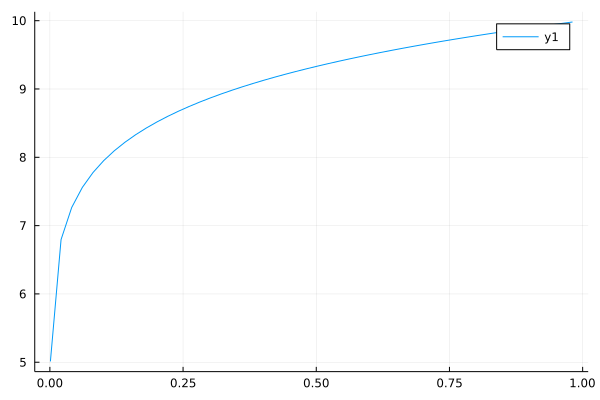

In [1]:
# State: x (cake in current period)
# Control: x' (cake in next period)
# V(x) = max{u(x-x') + βV(x')} s.t. 0<=x'<=x
# and g(x) = argmax{u(x-x') + βV(x')} s.t. 0<=x'<=x

β = 0.99
x0 = 1.0
ρ = 0.9
u(x) = x^(1-ρ)/(1-ρ) 

using Interpolations, Optim, Plots
n_X = 50
x_grid = LinRange(0.001:x0/n_X:x0)
N = size(x_grid)
v_grid = u.(x_grid)
xp_grid = (1-β).*x_grid

V = CubicSplineInterpolation(x_grid, v_grid, extrapolation_bc = Line())
g = CubicSplineInterpolation(x_grid, xp_grid, extrapolation_bc = Line());

plot(x_grid, V.(x_grid))

In [2]:

for i in 1:1:100
    v_grid = zeros(N)
    xp_grid = zeros(N)

    # For each state
    for (ix, x) in enumerate(x_grid)

        # define the RHS of the Bellman Operator
        function T(xp)
            if (0<=xp) & (xp<=x)
                return -u(x-xp)-β*V(xp)
            else 
                return Inf
            end
        end

        # and try to find the maximum of the RHS
        try 
            res = optimize(T, 0, x)
            v_grid[ix] = -Optim.minimum(res)
            xp_grid[ix] = Optim.minimizer(res)
        catch
            v_grid[ix] = V(x)
            xp_grid[ix] = (1-β)*x
            print(2)
        end
    end
    V = CubicSplineInterpolation(x_grid, v_grid, extrapolation_bc = Line())
    g = CubicSplineInterpolation(x_grid, xp_grid, extrapolation_bc = Line()) 
end

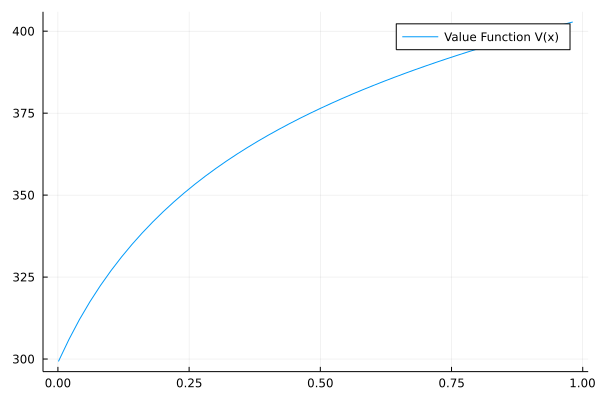

In [3]:
plot(x_grid, V.(x_grid), label = "Value Function V(x)")

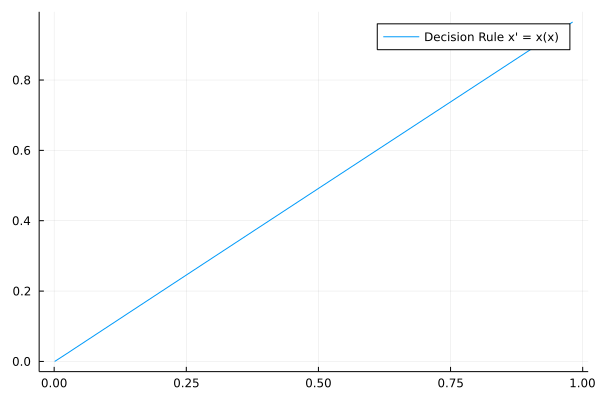

In [4]:
plot(x_grid, g.(x_grid), label = "Decision Rule x' = x(x)")

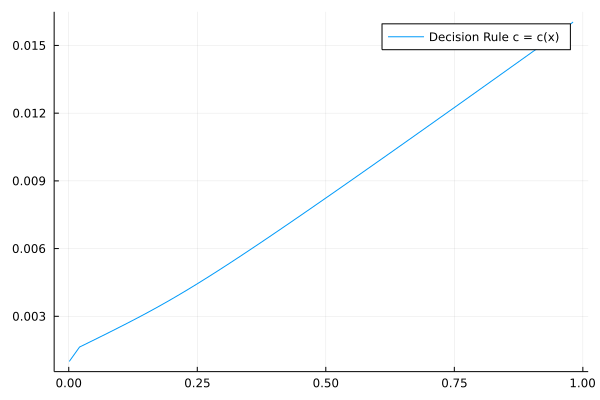

In [5]:
plot(x_grid, x_grid-g.(x_grid), label = "Decision Rule c = c(x)")

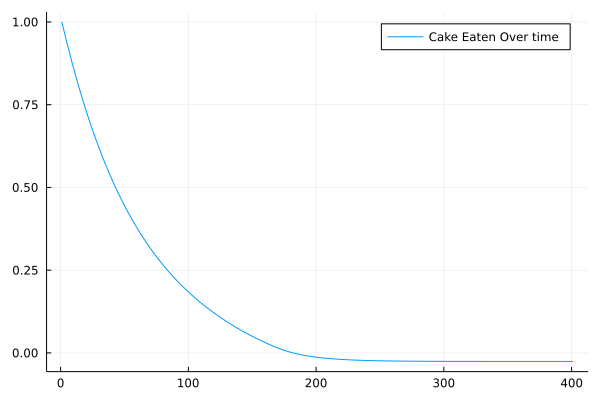

In [6]:
function simulate(x0, T)
    x_path = zeros(T+1)
    x_path[1] = x0
    for t in 2:1:T+1
        x_path[t] = g(x_path[t-1])
    end
    return x_path 
end

x_path = simulate(x0, 400)
plot(x_path, label = "Cake Eaten Over time")

# Habit Formation

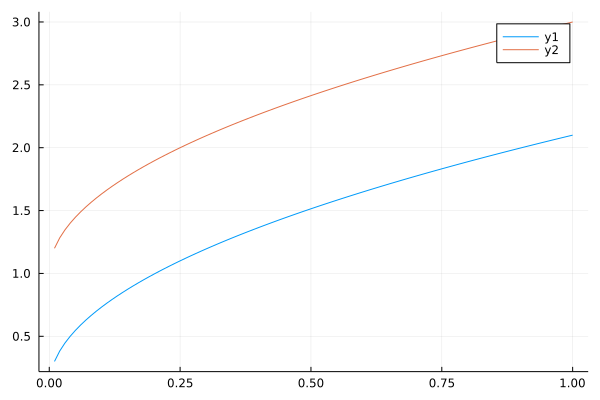

In [31]:
# State: x, c(-1)
# Control: x', c
# c(-1): c one period before
# V(x, c(-1)) = max{u(c, c(-1)) + βV(x', c)} s.t. 0<=x'<=x and c=x-x'

β = 0.95
ϕ = 0.5
x0 = 1.0
ρ = 0.5
u(c, c_) = c^(1-ρ)/(1-ρ) + ϕ*c_^(1-ρ)/(1-ρ) 

using Interpolations, Optim, Plots, LinearAlgebra
x_grid = LinRange(0.01:0.01:1)
c_grid = LinRange(0.01:0.01:1)
n_X = size(x_grid)[1]
n_C = size(c_grid)[1]
v_grid = @. u(x_grid, c_grid')
xp_grid = @. (1-β)* (x_grid + ϕ*c_grid')

V = CubicSplineInterpolation((x_grid, c_grid), v_grid, extrapolation_bc = Line())
g = CubicSplineInterpolation((x_grid, c_grid) , xp_grid, extrapolation_bc = Line());
plot(x_grid, V.(x_grid, c_grid[1]))
plot!(x_grid, V.(x_grid, c_grid[100]))

In [45]:
for i in 1:1:10
    v_grid = ones(n_X, n_C)
    xp_grid = ones(n_X, n_C)
    
    # For each state,
    for (ix, x) in enumerate(x_grid)
        for (ic_, c_) in enumerate(c_grid)
            
            # define the RHS of the Bellman Operator,
            function T(xp)
                if (0<=xp) & (xp<=x)
                    return - u(x-xp, c_) - β * V(xp, x-xp)
                else 
                    return Inf
                end
            end

            # find its maximum and update value for that state
            try 
                res = optimize(T, 0, x)
                v_grid[ix, ic_] = -Optim.minimum(res)
                xp_grid[ix, ic_] = Optim.minimizer(res)
            catch
                v_grid[ix, ic_] = V(x, c_)
                xp_grid[ix, ic_] = (1-β)*(x+ϕ*c_)
                print(2)
            end
        end
    end
    V = CubicSplineInterpolation((x_grid, c_grid), v_grid, extrapolation_bc = Line())
    g = CubicSplineInterpolation((x_grid, c_grid), xp_grid, extrapolation_bc = Line());
end

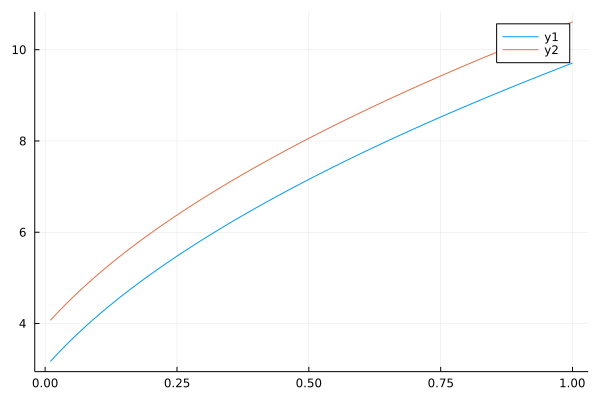

In [46]:
plot(x_grid, V.(x_grid, c_grid[1]))
plot!(x_grid, V.(x_grid, c_grid[100]))

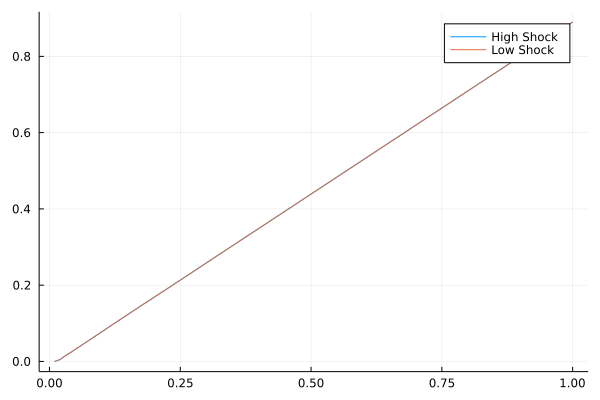

In [47]:
plot(x_grid, g.(x_grid, c_grid[1]), label = "High Shock")
plot!(x_grid, g.(x_grid, c_grid[2]), label = "Low Shock")

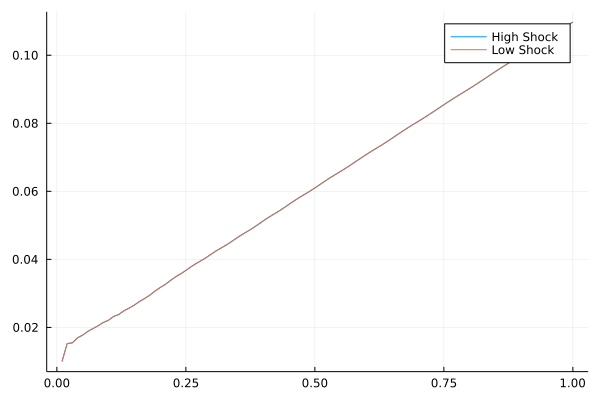

In [48]:
plot(x_grid, x_grid-g.(x_grid, c_grid[1]), label = "High Shock")
plot!(x_grid, x_grid-g.(x_grid, c_grid[100]), label = "Low Shock")

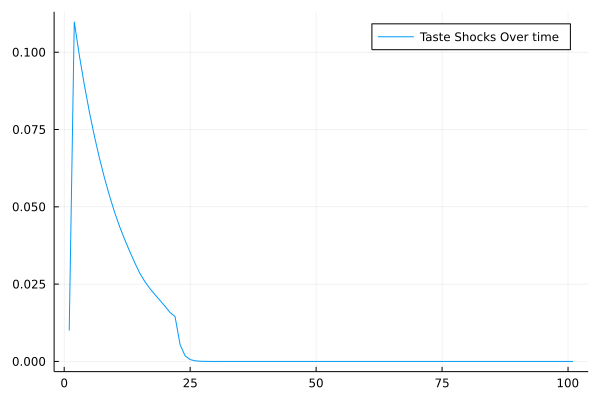

In [50]:
function simulate(x0, z0, T)
    x_path = zeros(T+1)
    c_path = zeros(T+1)
    x_path[1] = x0
    c_path[1] = z0
    for t in 2:1:T+1
        x_path[t] = g(x_path[t-1], c_path[t-1])
        c_path[t] = x_path[t-1] - x_path[t]
    end
    return x_path, c_path
end

x_path, c_path = simulate(1, c_grid[1], 100)
plot(c_path, label = "Taste Shocks Over time")

# Cake Eating - Taste Shocks

In [760]:
# High and Low Shocks to Utility
# x: cake in current period
# x': cake in next period
# z: random endowment shock
# V(x, z) = max u(x-x',z) + β*E[V(x', z')|z] s.t. 0<=x'<=x
# E[V(x', z')|z] = sum p(z'|z) V(x',z')
# p(z'=j|z = i) = (i,j) element of transition matrix P

β = 0.95
x0 = 1.0
ρ = 0.5
u(x, z) = z * x^(1-ρ)/(1-ρ)
P = [0.95 0.05; 0.05 0.95]
Z = [1 1.1]

using Interpolations, Optim, Plots, LinearAlgebra
x_grid = LinRange(0.01:0.001:1)
z_grid = LinRange(0.01:0.01:0.02)
n_X = size(x_grid)[1]
n_Z = size(z_grid)[1]
v_grid = @. u(x_grid, z_grid')
xp_grid = @. (1-β)*x_grid + z_grid'

V = CubicSplineInterpolation((x_grid, z_grid), v_grid, extrapolation_bc = Line())
g = CubicSplineInterpolation((x_grid, z_grid) , xp_grid, extrapolation_bc = Line());
n_Z, n_X, x_grid

(2, 991, range(0.01, stop=1.0, length=991))

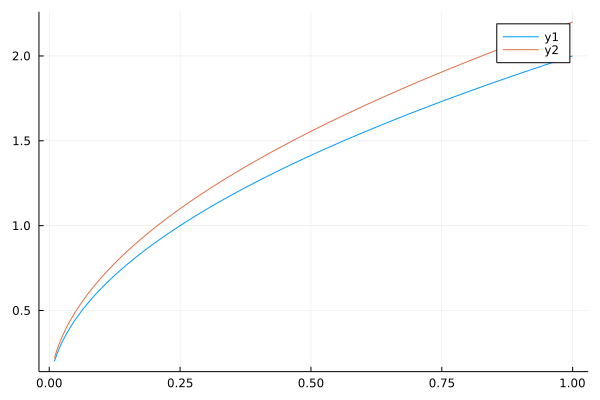

In [761]:
plot(x_grid, V.(x_grid, Z[1]))
plot!(x_grid, V.(x_grid, Z[2]))

In [762]:
for i in 1:1:100
    v_grid = ones(n_X, n_Z)
    xp_grid = ones(n_X, n_Z)
    
    # For each state,
    for (ix, x) in enumerate(x_grid)
        for (iz, z) in enumerate(z_grid)
            
            # define the RHS of the Bellman Operator,
            function T(xp)
                if (0<=xp) & (xp<=x)
                    return - u(x-xp, z) - β * dot(P[:, iz], V.(xp, Z))
                else 
                    return Inf
                end
            end

            # find its maximum and update value for that state
            try 
                res = optimize(T, 0, x)
                v_grid[ix, iz] = -Optim.minimum(res)
                xp_grid[ix, iz] = Optim.minimizer(res)
            catch
                v_grid[ix, iz] = V(x, z)
                xp_grid[ix, iz] = (1-β)*(x+z)
                print(2)
            end
        end
    end
    
    V = CubicSplineInterpolation((x_grid, z_grid), v_grid, extrapolation_bc = Line())
    g = CubicSplineInterpolation((x_grid, z_grid) , xp_grid, extrapolation_bc = Line());
end

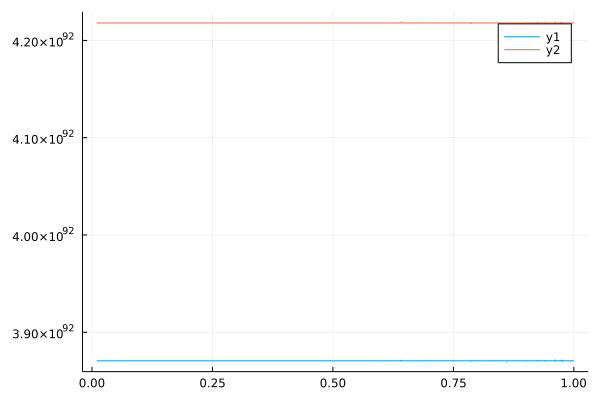

In [763]:
plot(x_grid, V.(x_grid, Z[1]))
plot!(x_grid, V.(x_grid, Z[2]))

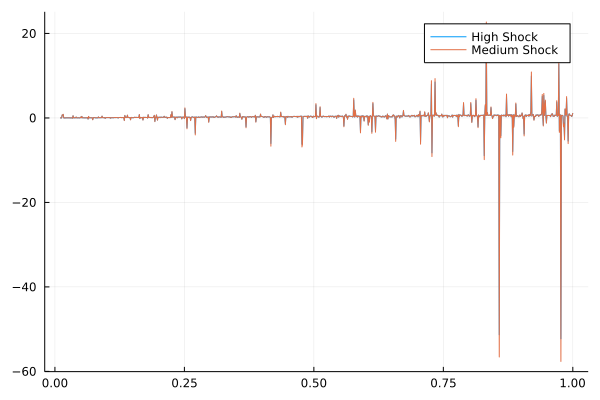

In [764]:
plot(x_grid, g.(x_grid, Z[1]), label = "High Shock")
plot!(x_grid, g.(x_grid, Z[2]), label = "Medium Shock")

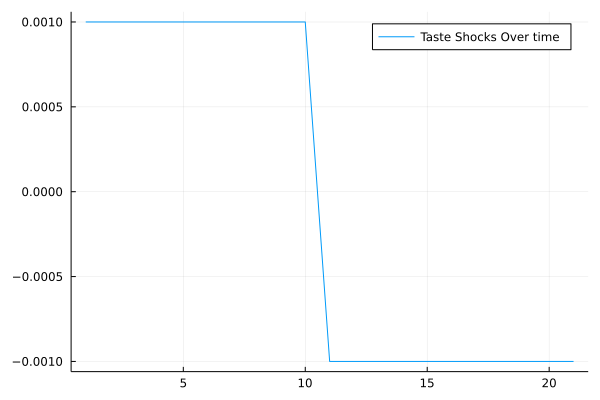

In [758]:
function simulate(x0, z0, T)
    x_path = zeros(T+1)
    z_path = zeros(T+1)
    x_path[1] = x0
    z_path[1] = z0
    for t in 2:1:T+1
        x_path[t] = g(x_path[t-1], z_path[t-1])
        iz = argmin(abs.(Z.- z_path[t-1]))[2]
        z_path[t] = sample(Z, Weights(P[iz, :]))
    end
    return x_path, z_path
end
    
x_path, z_path = simulate(1, Z[2], 20)

plot(z_path, label = "Taste Shocks Over time")

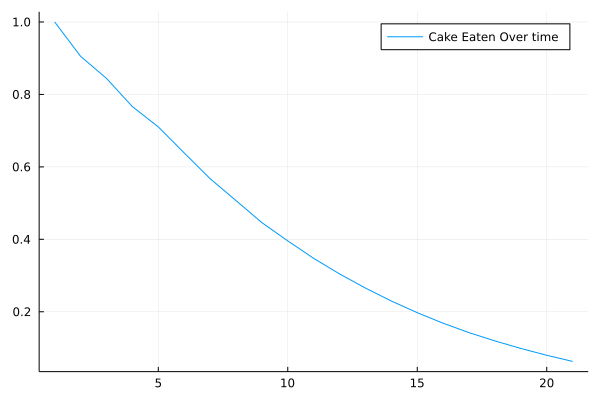

In [759]:
plot(x_path, label = "Cake Eaten Over time")